<a href="https://colab.research.google.com/github/vigeecarolina/Machine_learning_pricing_RENFE/blob/https%2Fcolab.research.google.com%2Fdrive%2F1tar5LJfTbEtB87W6UGDXAN7KuS55GugR/TP5/ML4_Pricing_RENFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REGRESION PRICING RENFE

**ENUNCIADO: Se pide completar el flujo completo de Regresion ML para entrenar un modelo de pricing de viajes de tren a partir de los datos de Renfe.**

* El dataset contiene la siguiente informacion de venta de tickets de trenes:
  * PRICE: Precio del billete (target)
  * ORIGIN: Origen del viaje.
  * DESTINATION: Destino del viaje.
  * DEPARTURE: Fecha hora de salida
  * ARRIVAL: Fecha hora de llegada
  * DURATION: Duracion estimada del trayecto
  * VEHICLE_TYPE: Tipo de tren
  * VEHICLE_CLASS: Clase de cabina
  * FARE: Tipo de tarifa
  * SEATS: asientos disponibles a este precio

* Fuente: https://www.kaggle.com/datasets/thegurusteam/spanish-high-speed-rail-system-ticket-pricing?select=thegurus-opendata-renfe-trips.csv

# Import libraries

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
import seaborn as sns
import missingno as msno

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy import stats

# Modelizacion
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Evaluacion
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_score
from sklearn import metrics
from xgboost import plot_tree
import shap
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

import pickle
plt.rcParams["figure.figsize"] = [10,6]

Dejo algunas funciones de ayuda...

# Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read traintest dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SUPERVISED ML/DSC - Regresion (III)/renfe_traintest.csv',index_col =0)

In [ ]:
df.head()

,origin,destination,departure,arrival,duration,vehicle_type,vehicle_class,price,fare,seats,insert_date
14387354,MADRID,VALENCIA,2019-08-29 16:55:00,2019-08-29 21:58:00,5.05,AVE-LD,Turista con enlace,39.25,Promo,NaN,2019-08-16 12:02:16
1888610,BARCELONA,MADRID,2019-04-30 12:50:00,2019-04-30 15:45:00,2.92,AVE-TGV,Turista,85.10,Promo,NaN,2019-04-18 22:20:08
22069490,MADRID,MALAGA,2020-04-26 15:35:00,2020-04-26 18:06:00,2.52,AVE,Preferente,73.85,Promo,NaN,2020-03-01 03:18:13
22152672,VALENCIA,MADRID,2020-04-17 18:10:00,2020-04-17 19:57:00,1.78,AVE,Turista,51.75,Promo,NaN,2020-03-01 18:54:54
14407416,SEVILLA,MADRID,2019-10-13 12:18:00,2019-10-13 14:56:00,2.63,ALVIA,Turista,67.20,Flexible,NaN,2019-08-16 15:36:19


In [ ]:
df.reset_index(drop=True,inplace=True)

# ML PREPROCESSING

## Duplicated rows and empty columns

In [ ]:
print(df.duplicated().sum(),'duplicated rows were deleted')
df.drop_duplicates(inplace=True)
print(df.shape)

326 duplicated rows were deleted
(199674, 11)


In [ ]:
print((df.isna().sum(axis=1)==df.shape[1]).sum(),'all-empty rows were deleted')
df.dropna(axis=0, how='all',inplace=True)
print(df.shape)

0 all-empty rows were deleted
(199674, 11)


In [ ]:
print(df['price'].isna().sum(),'rows with null target were deleted')
df.dropna(subset=['price'],inplace=True)

0 rows with null target were deleted


## Data types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199674 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   origin         199674 non-null  object 
 1   destination    199674 non-null  object 
 2   departure      199674 non-null  object 
 3   arrival        199674 non-null  object 
 4   duration       199674 non-null  float64
 5   vehicle_type   199674 non-null  object 
 6   vehicle_class  199674 non-null  object 
 7   price          199674 non-null  float64
 8   fare           199674 non-null  object 
 9   seats          8418 non-null    float64
 10  insert_date    199674 non-null  object 
dtypes: float64(3), object(8)
memory usage: 18.3+ MB


In [ ]:
for i in ('departure','arrival','insert_date'):
  df[i] = pd.to_datetime(df[i])

## Split X-y

In [ ]:
# Divide dataset en matriz de variables (X) y output (y)
target = 'price'
features = df.columns[df.columns!=target]

X = df[features]
y = df[target]

## EDA: Analisis exploratorio

(breve)

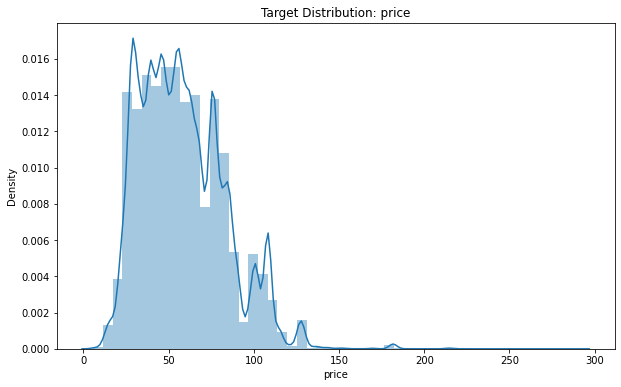

In [ ]:
sns.distplot(y)
plt.title('Target Distribution: '+target)
plt.show()

In [ ]:
y.describe().T

count    199674.000000
mean         58.265872
std          24.821777
min           5.650000
25%          39.250000
50%          55.700000
75%          75.400000
max         290.400000
Name: price, dtype: float64

In [ ]:
X.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
origin,199674,30,MADRID,98262,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
destination,199674,30,MADRID,99486,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
departure,199674,54857,2019-06-02 17:30:00,50,2019-04-12 09:40:00,2020-12-05 17:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival,199674,63951,2019-05-29 14:20:00,34,2019-04-12 11:24:00,2020-12-05 18:50:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,199674.0,NaN,NaN,NaN,NaT,NaT,2.893705,1.561707,0.37,1.87,2.53,3.13,12.42
vehicle_type,199674,30,AVE,133025,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vehicle_class,199674,10,Turista,155486,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fare,199674,10,Promo,106426,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seats,8418.0,NaN,NaN,NaN,NaT,NaT,220.079116,72.957453,6.0,205.0,238.0,262.0,334.0
insert_date,199674,164263,2020-09-30 20:00:00,105,2019-04-11 21:49:48,2020-10-07 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Correct categories

Algunos literales estan mal escritos.

In [ ]:
categories = df.select_dtypes(include='object').columns

In [ ]:
for i in categories:
  print(i)
  print(np.sort(X[i].unique()))

origin
['ALBACETE' 'ALICANTE' 'BARCELONA' 'CADIZ' 'CASTELLON' 'CIUDAD REAL'
 'CORDOBA' 'CUENCA' 'GIRONA' 'GRANADA' 'GUADALAJARA' 'HUESCA' 'LEON'
 'LLEIDA' 'MADRID' 'MALAGA' 'PALENCIA' 'PONFERRADA' 'SEGOVIA' 'SEVILLA'
 'TARRAGONA' 'TOLEDO' 'VALENCIA' 'VALLADOLID' 'ZAMORA' 'ZARAGOZA']
destination
['ALBACETE' 'ALICANTE' 'BARCELONA' 'CADIZ' 'CASTELLON' 'CIUDAD REAL'
 'CORDOBA' 'CUENCA' 'GIRONA' 'GRANADA' 'GUADALAJARA' 'HUESCA' 'LEON'
 'LLEIDA' 'MADRID' 'MALAGA' 'PALENCIA' 'PONFERRADA' 'SEGOVIA' 'SEVILLA'
 'TARRAGONA' 'TOLEDO' 'VALENCIA' 'VALLADOLID' 'ZAMORA' 'ZARAGOZA']
vehicle_type
['ALTARIA' 'ALVIA' 'AV CITY' 'AVANT' 'AVANT-AVE' 'AVANT-LD' 'AVANT-MD'
 'AVE' 'AVE-AVANT' 'AVE-AVE' 'AVE-LD' 'AVE-MD' 'AVE-TGV' 'AVLO' 'EUROMED'
 'INTERCITY' 'LD' 'LD-AVANT' 'LD-AVE' 'LD-MD' 'MD' 'MD-AVANT' 'MD-AVE'
 'MD-LD' 'R. EXPRES' 'REG.EXP.' 'REGIONAL' 'TORRE ORO' 'TRENHOTEL']
vehicle_class
['CAMA G. CLASE' 'CAMA TURISTA' 'PREFERENTE' 'PREFERENTESOLO PLAZA H'
 'TURISTA' 'TURISTA - TURISTA PLUS' 'TURISTA C

In [ ]:
# categorias en mayusculas
for i in categories:
  X[i] = X[i].str.upper()

In [ ]:
# eliminamos acentos
for i in categories:
  X[i] = X[i].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [ ]:
# CASTELLO -> CASTELLON
for i in ['destination','origin']:
  X[i] = X[i].replace('CASTELLO','CASTELLON')

## Feature Engineering (!)

In [ ]:
# Variables de las fechas
for i in ('departure','insert_date'):
  X['weekday_'+i] = X[i].dt.day_name()
  X['weekday_n_'+i] = X[i].dt.day_of_week # 0 -Lunes, 6-Domingo
  X['month_'+i] = X[i].dt.month
  X['hour_'+i] = X[i].dt.hour

In [ ]:
# Tiempo entre la consulta del precio y el viaje
timedelta = X.departure - X.insert_date
X['days_before_trip'] = timedelta.dt.days

In [ ]:
festivos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SUPERVISED ML/DSC - Regresion (III)/dias_festivos.csv')

In [ ]:
festivos = pd.to_datetime(festivos.values.flatten(), format='%d-%m-%Y')

In [ ]:
X['ind_weekend'] = X.weekday_n_departure.isin([5,6])

In [ ]:
X['ind_holidays'] = X.departure.dt.date.isin(festivos.date)

In [ ]:
X.columns

Index(['origin', 'destination', 'departure', 'arrival', 'duration',
       'vehicle_type', 'vehicle_class', 'fare', 'seats', 'insert_date',
       'weekday_departure', 'weekday_n_departure', 'month_departure',
       'hour_departure', 'weekday_insert_date', 'weekday_n_insert_date',
       'month_insert_date', 'hour_insert_date', 'days_before_trip',
       'ind_weekend', 'ind_holidays'],
      dtype='object')

In [ ]:
X.ind_holidays = X.ind_holidays.astype('int8')
X.ind_weekend = X.ind_weekend.astype('int8')

In [ ]:
X.origin.value_counts().index.values

array(['MADRID', 'BARCELONA', 'VALENCIA', 'SEVILLA', 'CORDOBA',
       'ZARAGOZA', 'PONFERRADA', 'VALLADOLID', 'MALAGA', 'ALBACETE',
       'TARRAGONA', 'LLEIDA', 'GIRONA', 'LEON', 'ALICANTE', 'CASTELLON',
       'GRANADA', 'SEGOVIA', 'CIUDAD REAL', 'PALENCIA', 'CUENCA',
       'TOLEDO', 'GUADALAJARA', 'CADIZ', 'ZAMORA', 'HUESCA'], dtype=object)

In [ ]:
# Hipotesis: los precios de las lineas de tren ida y vuelta son parecidos
# Vamos a ponerle nombre a las lineas de tren
# Definimos que el nombre de la linea será CIUDAD CON MAS VIAJES DE ORIGEN - CIUDAD CON MENOS VIAJES DE ORIGEN

city_order = X.origin.value_counts().index.values

def train_line(origin, destination, city_list):
  if np.where(city_order == origin) < np.where(city_order == destination):
    return origin+'-'+destination
  else:
    return destination+'-'+origin

# Aplicamos la funcion linea a linea en el dataframe
X['train_line'] = X.apply(lambda x: train_line(x['origin'], x['destination'], city_order), axis=1)

In [ ]:
X.head(3)

,origin,destination,departure,arrival,duration,vehicle_type,vehicle_class,fare,seats,insert_date,...,month_departure,hour_departure,weekday_insert_date,weekday_n_insert_date,month_insert_date,hour_insert_date,days_before_trip,ind_weekend,ind_holidays,train_line
0,MADRID,VALENCIA,2019-08-29 16:55:00,2019-08-29 21:58:00,5.05,AVE-LD,TURISTA CON ENLACE,PROMO,NaN,2019-08-16 12:02:16,...,8,16,Friday,4,8,12,13,0,0,MADRID-VALENCIA
1,BARCELONA,MADRID,2019-04-30 12:50:00,2019-04-30 15:45:00,2.92,AVE-TGV,TURISTA,PROMO,NaN,2019-04-18 22:20:08,...,4,12,Thursday,3,4,22,11,0,0,MADRID-BARCELONA
2,MADRID,MALAGA,2020-04-26 15:35:00,2020-04-26 18:06:00,2.52,AVE,PREFERENTE,PROMO,NaN,2020-03-01 03:18:13,...,4,15,Sunday,6,3,3,56,1,0,MADRID-MALAGA


In [ ]:
X.columns

Index(['origin', 'destination', 'departure', 'arrival', 'duration',
       'vehicle_type', 'vehicle_class', 'fare', 'seats', 'insert_date',
       'weekday_departure', 'weekday_n_departure', 'month_departure',
       'hour_departure', 'weekday_insert_date', 'weekday_n_insert_date',
       'month_insert_date', 'hour_insert_date', 'days_before_trip',
       'ind_weekend', 'ind_holidays', 'train_line'],
      dtype='object')

In [ ]:
#Drop de variables que son fechas
X.drop(columns=['departure','arrival','insert_date'], inplace=True)

## Nulls

In [ ]:
100*X.isna().sum()/X.shape[0]

origin                    0.000000
destination               0.000000
duration                  0.000000
vehicle_type              0.000000
vehicle_class             0.000000
fare                      0.000000
seats                    95.784128
weekday_departure         0.000000
weekday_n_departure       0.000000
month_departure           0.000000
hour_departure            0.000000
weekday_insert_date       0.000000
weekday_n_insert_date     0.000000
month_insert_date         0.000000
hour_insert_date          0.000000
days_before_trip          0.000000
ind_weekend               0.000000
ind_holidays              0.000000
train_line                0.000000
dtype: float64

In [ ]:
X.drop(columns='seats',inplace=True)

## One-hot-encoding

In [ ]:
categorical = X.select_dtypes(include='object').columns

In [ ]:
X[categorical].nunique()

origin                 26
destination            26
vehicle_type           29
vehicle_class          10
fare                   10
weekday_departure       7
weekday_insert_date     7
train_line             27
dtype: int64

In [ ]:
for i in categorical:
  print(i)
  print('Unique vanlues:', X[i].nunique())
  print(100*X[i].value_counts()/X.shape[0])
  print()

origin
Unique vanlues: 26
MADRID         49.211214
BARCELONA      12.464818
VALENCIA        9.891623
SEVILLA         9.831025
CORDOBA         3.190200
ZARAGOZA        2.748480
PONFERRADA      2.308262
VALLADOLID      2.179052
MALAGA          1.212476
ALBACETE        1.123832
TARRAGONA       1.120827
LLEIDA          0.886946
GIRONA          0.871921
LEON            0.726184
ALICANTE        0.686619
CASTELLON       0.546891
GRANADA         0.370103
SEGOVIA         0.128710
CIUDAD REAL     0.115188
PALENCIA        0.095656
CUENCA          0.077627
TOLEDO          0.064104
GUADALAJARA     0.058596
CADIZ           0.039064
ZAMORA          0.028046
HUESCA          0.022537
Name: origin, dtype: float64

destination
Unique vanlues: 26
MADRID         49.824213
BARCELONA      12.970642
VALENCIA       10.335847
SEVILLA         9.820007
CORDOBA         3.050472
ZARAGOZA        2.788045
VALLADOLID      2.144996
PONFERRADA      1.541012
MALAGA          1.219488
ALBACETE        1.117321
TARRAGONA    

In [ ]:
# Definimos como residual todo valor con una frecuencia por debajo del 5%
# min_weight = 0.05
# for i in categorical:
#   count = X[i].value_counts() / X.shape[0]
#   most_frequent = count[count>0.05].index.to_list()
#   X[i] = X[i].apply(lambda x: x if x in most_frequent else 'OTRO')

In [ ]:
X = pd.get_dummies(data=X,
                  columns=categorical,
                  dtype="int8")

In [ ]:
X.head(3)

,duration,weekday_n_departure,month_departure,hour_departure,weekday_n_insert_date,month_insert_date,hour_insert_date,days_before_trip,ind_weekend,ind_holidays,...,train_line_MADRID-PALENCIA,train_line_MADRID-PONFERRADA,train_line_MADRID-SEGOVIA,train_line_MADRID-SEVILLA,train_line_MADRID-TARRAGONA,train_line_MADRID-TOLEDO,train_line_MADRID-VALENCIA,train_line_MADRID-VALLADOLID,train_line_MADRID-ZAMORA,train_line_MADRID-ZARAGOZA
0,5.05,3,8,16,4,8,12,13,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2.92,1,4,12,3,4,22,11,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.52,6,4,15,6,3,3,56,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.shape

(199674, 152)

## Remove High-correlation

In [ ]:
def highly_correlated(X, y, threshold):
    col_corr = list() # Set of all the names of deleted columns
    colnames = list()
    rownames = list()
    corr_matrix = X.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colnames.append(corr_matrix.columns[i]) # getting the name of column
                rownames.append(corr_matrix.index[j])
                col_corr.append(corr_matrix.iloc[i, j])
    Z = pd.DataFrame({'F1':colnames,
                      'F2':rownames,
                      'corr_F1_F2':col_corr,
                      'corr_F1_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in colnames],
                      'corr_F2_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in rownames]
                      })
    Z['F_to_delete'] = rownames
    Z['F_to_delete'][Z['corr_F1_target'] < Z['corr_F2_target']] = Z['F1'][Z['corr_F1_target'] < Z['corr_F2_target']]

    return Z

highly_corr = highly_correlated(X,y,0.95)
highly_corr

,F1,F2,corr_F1_F2,corr_F1_target,corr_F2_target,F_to_delete
0,fare_BASICA,vehicle_type_AVLO,1.0,0.044525,0.044525,vehicle_type_AVLO


In [ ]:
X.drop(columns=['vehicle_type_AVLO'], inplace=True)

## Remove Low-variance

In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
vt = VarianceThreshold(threshold = 0.01) #Eliminamos columnas donde el 99% de los valores son iguales
vt.fit(X)
cols_lowvar = X.columns[vt.get_support()==False]
print(len(cols_lowvar),' low variance features will be removed:\n', cols_lowvar.to_list())

72  low variance features will be removed:
 ['origin_ALICANTE', 'origin_CADIZ', 'origin_CASTELLON', 'origin_CIUDAD REAL', 'origin_CUENCA', 'origin_GIRONA', 'origin_GRANADA', 'origin_GUADALAJARA', 'origin_HUESCA', 'origin_LEON', 'origin_LLEIDA', 'origin_PALENCIA', 'origin_SEGOVIA', 'origin_TOLEDO', 'origin_ZAMORA', 'destination_ALICANTE', 'destination_CADIZ', 'destination_CASTELLON', 'destination_CIUDAD REAL', 'destination_CUENCA', 'destination_GIRONA', 'destination_GRANADA', 'destination_GUADALAJARA', 'destination_HUESCA', 'destination_LEON', 'destination_LLEIDA', 'destination_PALENCIA', 'destination_SEGOVIA', 'destination_TOLEDO', 'destination_ZAMORA', 'vehicle_type_ALTARIA', 'vehicle_type_AVANT-AVE', 'vehicle_type_AVANT-LD', 'vehicle_type_AVANT-MD', 'vehicle_type_AVE-AVANT', 'vehicle_type_AVE-AVE', 'vehicle_type_AVE-MD', 'vehicle_type_AVLO', 'vehicle_type_EUROMED', 'vehicle_type_LD', 'vehicle_type_LD-AVANT', 'vehicle_type_LD-MD', 'vehicle_type_MD-AVANT', 'vehicle_type_MD-AVE', 'vehic

In [ ]:
X.drop(columns=cols_lowvar,inplace=True)

In [ ]:
X.shape

(199674, 80)

# Split TRAIN-TEST

Para este ejercicio vamos a utilizar todos el mismo TEST. Como los datos de origen ya estan ordenados aleatoriamente, vamos a tomar para TEST el ultimo 20% de los dataset.

In [ ]:
test_rate = 0.2
total_rows = len(y)
test_size = int(test_rate*total_rows)
train_size = total_rows - test_size

print('TRAIN-VALIDA: %d (%.1f%%)' %(train_size,(100-test_rate*100)))
print('TEST: %d (%.1f%%)' %(test_size,(test_rate*100)))

TRAIN-VALIDA: 159740 (80.0%)
TEST: 39934 (20.0%)


In [ ]:
X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

# Rescaling

Para los modelos lineales (linear_models) y los modelos de similitud (KNN), utilizaremos un dataset estandarizado. Para los modelos de reglas (todos los ensembles) no es necesario.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [ ]:
#la funcion scaler nos devuelve un numpy.matrix, le devolvemos el formato de dataframe
X_train_std = pd.DataFrame(data = X_train_std, columns=X_train.columns, index=X_train.index)
X_test_std = pd.DataFrame(data = X_test_std, columns=X_test.columns, index=X_test.index)

In [ ]:
X_train_std.head(3)

,duration,weekday_n_departure,month_departure,hour_departure,weekday_n_insert_date,month_insert_date,hour_insert_date,days_before_trip,ind_weekend,ind_holidays,...,train_line_MADRID-GIRONA,train_line_MADRID-LEON,train_line_MADRID-LLEIDA,train_line_MADRID-MALAGA,train_line_MADRID-PONFERRADA,train_line_MADRID-SEVILLA,train_line_MADRID-TARRAGONA,train_line_MADRID-VALENCIA,train_line_MADRID-VALLADOLID,train_line_MADRID-ZARAGOZA
0,1.379121,0.073285,1.040178,0.578145,0.477211,1.481247,0.056044,-0.858330,-0.565986,-0.137782,...,-0.128379,-0.111944,-0.125836,-0.157069,-0.200273,-0.493585,-0.147049,2.003567,-0.213277,-0.229068
1,0.017479,-0.942905,-0.718862,-0.274059,-0.034267,-0.299063,1.527285,-0.958847,-0.565986,-0.137782,...,-0.128379,-0.111944,-0.125836,-0.157069,-0.200273,-0.493585,-0.147049,-0.499110,-0.213277,-0.229068
2,-0.238229,1.597569,-0.718862,0.365094,1.500168,-0.744141,-1.268073,1.302788,1.766829,-0.137782,...,-0.128379,-0.111944,-0.125836,6.366637,-0.200273,-0.493585,-0.147049,-0.499110,-0.213277,-0.229068


# TRAIN-VALIDA

## Model Competition

In [ ]:
# Modelos ML de Regresion
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [ ]:
def RMSE(model,X,y):
  return round(np.sqrt(np.mean((y-model.predict(X))**2)),2)

def RMSE_cross_validation(model,X,y):
  Kfold_rmse = cross_val_score(model, X, y, cv=3, scoring='neg_root_mean_squared_error')
  return round(-Kfold_rmse.mean(),2)

In [ ]:
# Inicializa registros del dataframe
label_ = []
rmse_train_ = []
rmse_valida_ = []

# Funcion que devuelve un dataframe con los resultados de RMSE en Train y Cross Validation y rankea resultados
def evaluate_regression(label,model, X, y, verbose=True, cv=True):

  model.fit(X,y)
  rmse_train = RMSE(model,X,y)
  cross_valida = RMSE_cross_validation(model,X,y)

  label_.append(label)
  rmse_train_.append(rmse_train)
  if cv==True:
    rmse_valida_.append(cross_valida)
  else:
    rmse_valida_.append(-1)

  if verbose==True:
    return pd.DataFrame({'Model': label_,
                       'RMSE Train': rmse_train_,
                       'RMSE Cross-Valida': rmse_valida_
                       }).sort_values('RMSE Cross-Valida')

In [ ]:
evaluate_regression('Linear Regression',LinearRegression(),X_train_std,y_train)

,Model,RMSE Train,RMSE Cross-Valida
0,Linear Regression,10.67,10.68


In [ ]:
evaluate_regression('XGBoost',XGBRegressor(objective='reg:squarederror'),X_train_std,y_train)

[14:39:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:40:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:40:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:41:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:41:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:42:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Model,RMSE Train,RMSE Cross-Valida
1,XGBoost,8.71,8.71
0,Linear Regression,10.67,10.68


## Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
params = {
    'n_estimators': [100,500,1000],
    'max_depth': [3, 5],
    'min_child_weight': [2, 4],
    'subsample': [0.7,1]
}

In [ ]:
search_hp = RandomizedSearchCV(estimator = XGBRegressor(),
                   param_distributions = params,
                   n_iter = 5,
                   scoring= 'neg_squared_error',
                   n_jobs= -1,
                   cv= 3,
                   verbose=True)

In [ ]:
search_hp.fit(X_train,y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[16:14:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=2, estimator=XGBRegressor(), n_iter=3, n_jobs=-1,
                   param_distributions={'max_depth': [3, 5],
                                        'min_child_weight': [2, 4],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': [0.7, 1]},
                   scoring='roc_auc', verbose=True)

In [ ]:
search_hp.best_params_

{'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 3}

In [ ]:
search_hp.score_

## Select best model

Seleccionaremos el modelo hiperparametrizado si consigue mejorar a la parametrizacion por default (la de la competicion de modelos). De lo contrario entrenamos el modelo con la configuracion default.

In [ ]:
best_model = search_hp.best_estimator_

# TEST

Mediremos el error que el modelo produce la regresión en el TEST data.

In [ ]:
y_train_pred = best_model.predict(X_train)              # predicciones del modelo en los datos de TRAIN
y_test_pred = best_model.predict(X_test)                # predicciones del modelo en los datos de TEST

* **RMSE, MAE y MAPE**

In [ ]:
error = y_test_pred - y_test.values

mae = np.mean(np.abs(error))
mape = np.mean(error/y_test)
mse = np.mean(error**2)
rmse = np.sqrt(np.mean(error**2))

print('RMSE:', round(rmse,4))
print('MAE:', round(mae,4))
print('MAPE: {:.3%}'.format(mape))
print('R2-Score: {:.2%}'.format(r2_score(y_test, y_test_pred)))

RMSE: 7.3122
MAE: 5.125
MAPE: 2.342%
R2-Score: 91.31%


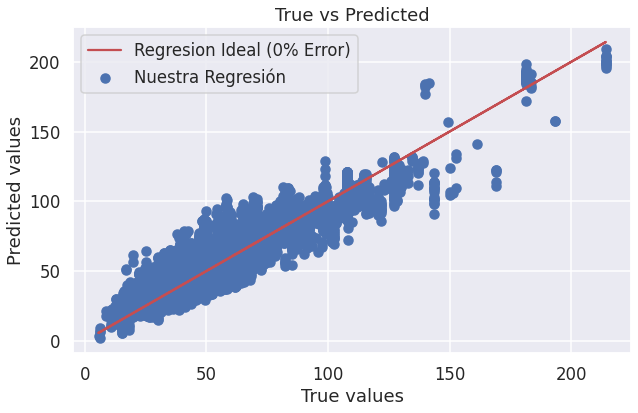

In [ ]:
#Compara Prediccion vs dato real
plt.figure(figsize=[10,6])
plt.scatter(y_test,y_test_pred)
plt.plot(y_test,y_test,'r')
plt.title('True vs Predicted')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(['Regresion Ideal (0% Error)','Nuestra Regresión'])
plt.show()

**Distribución del error**

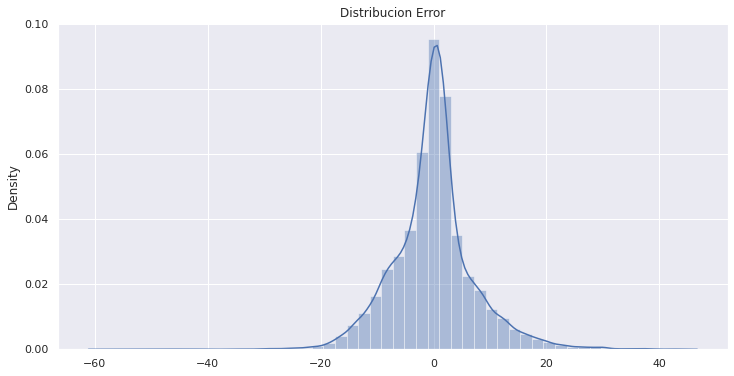

In [ ]:
sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(error).set_title('Distribucion Error')
plt.show()

In [ ]:
round(pd.Series(error).describe(),2)

count    39934.00
mean        -0.02
std          7.31
min        -58.51
25%         -3.71
50%          0.04
75%          2.94
max         44.09
dtype: float64

**Error interval:**

In [ ]:
confidence=95
z = (100-confidence)/2
print("Intervalo del error (confianza",confidence,"%):",round(np.percentile(error, 100-z),1),"/",round(np.percentile(error, z),1))

Intervalo del error (confianza 95 %): 16.4 / -14.3


# Interpretability

Visualizaremos TOP FEATURES y, en caso de ser un modelo de REGLAS, visualizaremos el arbol de decision.

* Articulo detallando las metricas de evaluacion del XGBoost: https://mljar.com/blog/feature-importance-xgboost/
  * **Feature Importance (weight)**: basado en la presencia de la variable en las ramas de los arboles del modelo.
  * **SHAP value (mean)**: analisis variable a variable del impacto promedio en el output que causa una desviación en esta variable.
  * **SHAP value distribution**: sentido del impacto (positivo o negativo) con respecto al target.

* Feature importance

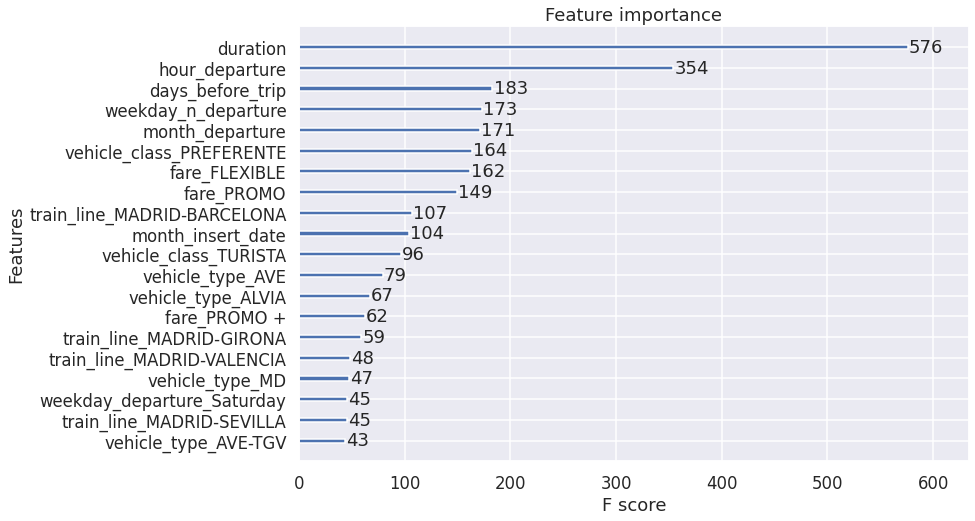

In [ ]:
# Feature importance: numero de veces que emplea la variable para determinar el output
rcParams['figure.figsize'] = 12,8
sns.set(context="talk")
xgb.plot_importance(best_model, max_num_features=20, importance_type='weight')
plt.show()

* SHAP values

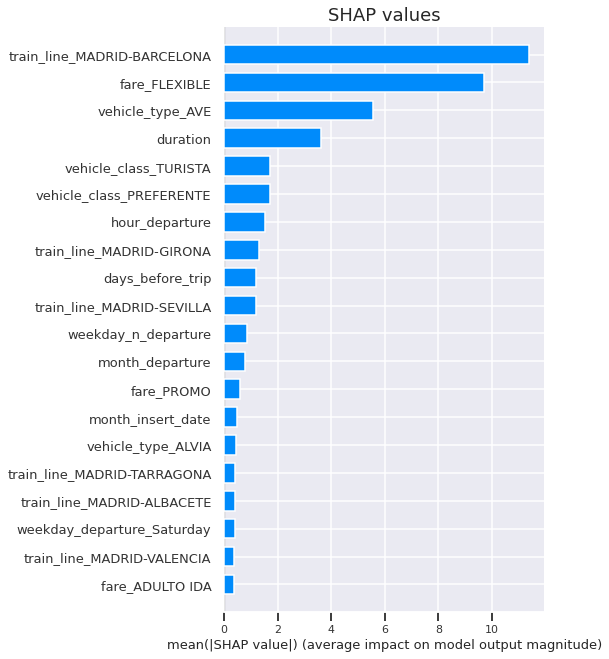

In [ ]:
#SHAP value: peso en el output final
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
plt.title('SHAP values')
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)

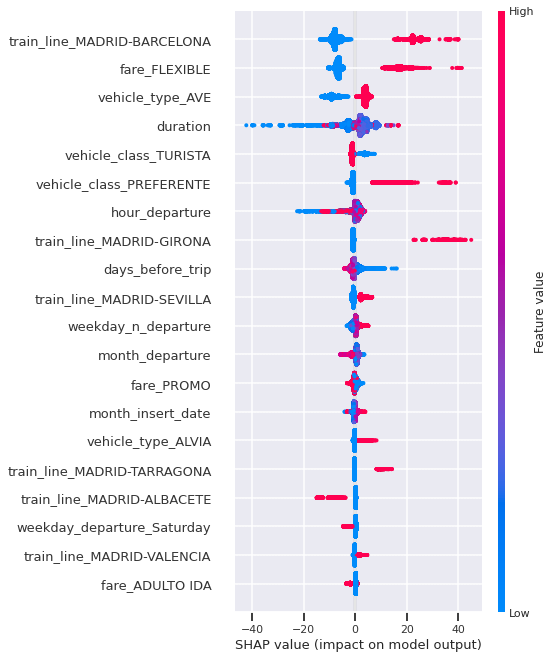

In [ ]:
shap.summary_plot(shap_values, X_test)

* Decision Trees

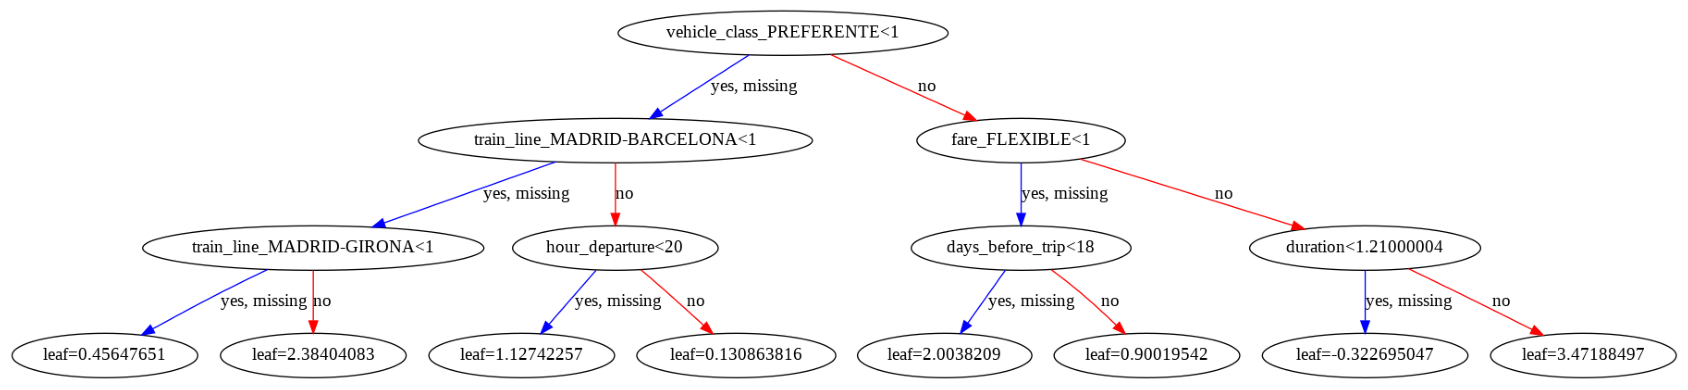

In [ ]:
# Visualiza un árbol concreto de los [n_estimators] que utiliza el XGBoost
plt.rcParams["figure.figsize"] =[30, 20]
plot_tree(best_model, num_trees=20)
plt.show()

# Save model

In [ ]:
pickle.dump(my_model, open('my_model.pkl', 'wb'))

# PREDICT

## OPCION A) Generar listado de predicts

Se pide hacer predicciones de precio para los datos de validacion y calcular el RMSE en validacion

In [ ]:
# Read predict dataset
X_pred = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/3 - Regresion/DSC - Regresion (III)/renfe_predict.csv')

In [ ]:
X_pred.head(3)

**Hay que replicar pasos del preprocessing en dataset validacion**
1. Cambios de formato
2. Feature Engineering
3. One hot encoding
4. Eliminacion de columnas
5. Estandarizacion de X (aplicar el mismo .transform)

In [ ]:
#Importa modelo
model = pickle.load(open('my_model.pkl', 'rb'))

## OPCION B) Predict ficticio (si no diese tiempo la opcion A)

¿Cuanto costará un billete de AVE Barcelona -> Madrid (2.6h) en clase Turista y tarifa Promo un Domingo 5 de Mayo a las 18h a 10 dias del viaje?
<br><br>
Crea un registro ficticio de las variables acorde al caso y haz un predict con esos datos.

In [ ]:
X_train.columns